In [255]:
import requests
import config
from bs4 import BeautifulSoup as BS
import mysql.connector
import pandas as pd

In [215]:
import seaborn as sns
import matplotlib.pyplot as plt

In [184]:
import mysql_functions
from statsmodels.formula.api import ols
import statsmodels.api as sm

AttributeError: module 'config' has no attribute 'password'

In [256]:
cnx = mysql.connector.connect(
  host=config.hostj,
  user=config.userj,
  passwd=config.pwj,
  database = 'nfl_draft_info')

cursor = cnx.cursor()

In [258]:
cnx.commit()

In [257]:
cursor.execute("""SHOW TABLES""")
cursor.fetchall()

[('draft_picks',), ('nfl_combine_info',)]

In [261]:
cursor.description

[('row_id', 3, None, None, None, None, 0, 49667),
 ('player', 253, None, None, None, None, 1, 0),
 ('year', 3, None, None, None, None, 1, 32768),
 ('position', 253, None, None, None, None, 1, 0),
 ('school', 253, None, None, None, None, 1, 0),
 ('height', 253, None, None, None, None, 1, 0),
 ('weight', 3, None, None, None, None, 1, 32768),
 ('40yd', 246, None, None, None, None, 1, 32768),
 ('vertical', 246, None, None, None, None, 1, 32768),
 ('bench', 3, None, None, None, None, 1, 32768),
 ('broad_jump', 3, None, None, None, None, 1, 32768),
 ('3cone', 246, None, None, None, None, 1, 32768),
 ('shuttle', 246, None, None, None, None, 1, 32768),
 ('pick_number', 3, None, None, None, None, 1, 32768)]

In [274]:
cursor.execute("""SELECT COUNT(*) FROM nfl_combine_info WHERE broad_jump = 0""")
cursor.fetchall()

[(1535,)]

In [127]:
cursor.execute("""CREATE TABLE draft_picks(
                id INT NOT NULL AUTO_INCREMENT PRIMARY KEY,
                pick_number INT,
                name VARCHAR(100),
                position VARCHAR(10),
                college VARCHAR(50),
                year INT
                )""")

In [74]:
def get_draft_info(year):
    draft_page = requests.get("https://www.pro-football-reference.com/years/" + str(year) + "/draft.htm")
    draft_soup = BS(draft_page.content, 'html.parser')
    draft_html = list(draft_soup.children)[3]
    draft_body = list(draft_html.children)[3]
    draft_table = list(draft_body.children)[1]
    draft_info = list(draft_table.children)[11]
    draft_info_table = list(draft_info.children)[9]
    draft_detail = list(draft_info_table.children)[3]
    dtable = draft_detail.find("table")
    drows = dtable.findAll('tr')
    ddata = [[td.findChildren(text=True) for td in tr.findAll("td")] for tr in drows]
    ddata2 = []
    for i in ddata:
        if len(i) == 28:
            ddata2.append({'pick': i[0], 'name': i[2], 'position': i[3], 'college': i[-2], 'year': year})
    return ddata2

In [75]:
results00 = get_draft_info(2000)

In [76]:
results00

[{'pick': ['1'],
  'name': ['Courtney Brown'],
  'position': ['DE'],
  'college': ['Penn St.'],
  'year': 2000},
 {'pick': ['2'],
  'name': ['LaVar Arrington'],
  'position': ['LB'],
  'college': ['Penn St.'],
  'year': 2000},
 {'pick': ['3'],
  'name': ['Chris Samuels'],
  'position': ['T'],
  'college': ['Alabama'],
  'year': 2000},
 {'pick': ['4'],
  'name': ['Peter Warrick'],
  'position': ['WR'],
  'college': ['Florida St.'],
  'year': 2000},
 {'pick': ['5'],
  'name': ['Jamal Lewis'],
  'position': ['RB'],
  'college': ['Tennessee'],
  'year': 2000},
 {'pick': ['6'],
  'name': ['Corey Simon'],
  'position': ['DT'],
  'college': ['Florida St.'],
  'year': 2000},
 {'pick': ['7'],
  'name': ['Thomas Jones'],
  'position': ['RB'],
  'college': ['Virginia'],
  'year': 2000},
 {'pick': ['8'],
  'name': ['Plaxico Burress'],
  'position': ['WR'],
  'college': ['Michigan St.'],
  'year': 2000},
 {'pick': ['9'],
  'name': ['Brian Urlacher', ' ', 'HOF'],
  'position': ['LB'],
  'college': [

In [77]:
for sub in results00:
    for key in sub:
        sub[key] = str(sub[key]).strip("['']")

In [78]:
for sub in results00:
    sub['pick'] = int(sub['pick'])

In [79]:
for sub in results00:
    sub['year'] = int(sub['year'])

In [88]:
results00[0]

{'pick': 1,
 'name': 'Courtney Brown',
 'position': 'DE',
 'college': 'Penn St.',
 'year': 2000}

In [91]:
draft_list = []
for player in results00:
    draft_list.append((player['pick'], player['name'], player['position'], player['college'], player['year']))

In [98]:
stmt = "INSERT INTO nfl_draft_info.draft_picks (pick_number, name, position, college, year) VALUES (%s, %s, %s, %s, %s)"
cursor.executemany(stmt, draft_list)

In [105]:
def insert_into_draft_table(year1, year2):
    for i in range(year1, year2):
        draft_results = get_draft_info(i)
        for sub in draft_results:
            for key in sub:
                sub[key] = str(sub[key]).strip("['']")
        for sub in draft_results:
            sub['pick'] = int(sub['pick'])
        for sub in draft_results:
            sub['year'] = int(sub['year'])
        draft_list = []
        for player in draft_results:
            draft_list.append((player['pick'], player['name'], player['position'], player['college'], player['year']))
        stmt = "INSERT INTO nfl_draft_info.draft_picks (pick_number, name, position, college, year) VALUES (%s, %s, %s, %s, %s)"
        cursor.executemany(stmt, draft_results)
        cnx.commit()    
    

In [111]:
def get_draft_list(year1, year2):
    draft_results_list = []
    for i in range(year1, year2):
        draft_results = get_draft_info(i)
        for sub in draft_results:
            for key in sub:
                sub[key] = str(sub[key]).strip("['']")
        for sub in draft_results:
            sub['pick'] = int(sub['pick'])
        for sub in draft_results:
            sub['year'] = int(sub['year'])
        draft_results_list.append(draft_results)
    return draft_results_list
        #draft_list = []
        #for player in draft_results:
            #draft_list.append((player['pick'], player['name'], player['position'], player['college'], player['year']))
    #return draft_list

In [119]:
def get_full_player_list(year1, year2):
    draft_results_ld = get_draft_list(year1, year2)
    draft_list = []
    for year in draft_results_ld:
        for player in year:
            draft_list.append((player['pick'], player['name'], player['position'], player['college'], player['year']))
    return draft_list
#             stmt = "INSERT INTO nfl_draft_info.draft_picks (pick_number, name, position, college, year) VALUES (%s, %s, %s, %s, %s)"
#             cursor.executemany(stmt, draft_results_ld)
#             cnx.commit()

In [159]:
draft_list = get_full_player_list(2000,2001)

In [122]:
def insert_into_sql(dlist):
    stmt = "INSERT INTO nfl_draft_info.draft_picks (pick_number, name, position, college, year) VALUES (%s, %s, %s, %s, %s)"
    cursor.executemany(stmt, dlist)
    cnx.commit()

In [160]:
insert_into_sql(draft_list)

In [163]:
cursor.execute("""SELECT id, pick_number, name, position, year FROM draft_picks""")
draft_picks = cursor.fetchall()

In [164]:
draft_picks[0]

(1, 1, 'Michael Vick', 'QB', 2001)

In [165]:
df = pd.DataFrame(draft_picks, columns = ['id', 'pick', 'name', 'position', 'year'])
df = df.set_index('id')
df.tail()

,pick,name,position,year
id,,,,
5091,250,Ethan Howell,WR,2000
5092,251,DaShon Polk,LB,2000
5093,252,Rondell Mealey,RB,2000
5094,253,Alfonso Boone,DT,2000
5095,254,Michael Green,DB,2000


In [174]:
df[df['name'].str.contains('HOF')]

,pick,name,position,year
id,,,,
1313,34,"""D'Qwell Jackson""",LB,2006


In [171]:
df = df.replace("Brian Urlacher', ' ', 'HOF", "Brian Urlacher")

In [172]:
df.head()

,pick,name,position,year
id,,,,
1,1,Michael Vick,QB,2001
2,2,Leonard Davis,T,2001
3,3,Gerard Warren,DT,2001
4,4,Justin Smith,DE,2001
5,5,Ladanian Tomlinson,RB,2001


In [188]:
def get_all_combine_data():
    get_data = ('(SELECT *  FROM nfl_combine_info)')
    cursor.execute(get_data)
    return cursor.fetchall()

In [191]:
def create_combine_data_frame():
    data = get_all_combine_data()
    df2 = pd.DataFrame(data, columns = ['row_id', 'player', 'year', 'position', 'school', 'height', 'weight', '40yd', 'vertical', 'bench', 'broad_jump', '3cone', 'shuttle', 'pick_number'])
    df2 = df2.set_index('row_id')
    return df2

In [207]:
df_combine = create_combine_data_frame()

In [208]:
df_combine.head()

,player,year,position,school,height,weight,40yd,vertical,bench,broad_jump,3cone,shuttle,pick_number
row_id,,,,,,,,,,,,,
1,John Abraham,2000,OLB,South Carolina,6-4,252,4.55000000,None,NaN,NaN,None,None,13.0
2,Shaun Alexander,2000,RB,Alabama,6-0,218,4.58000000,None,NaN,NaN,None,None,19.0
3,Darnell Alford,2000,OT,Boston Col.,6-4,334,5.56000000,25.00000000,23.0,94.0,8.48000000,4.98000000,188.0
4,Kyle Allamon,2000,TE,Texas Tech,6-2,253,4.97000000,29.00000000,NaN,104.0,7.29000000,4.49000000,NaN
5,Rashard Anderson,2000,CB,Jackson St.,6-2,206,4.55000000,34.00000000,NaN,123.0,7.18000000,4.15000000,23.0


In [200]:
def parse_ht(ht):
    # format: 7' 0.0"
    ht_ = ht.split("-")
    ft_ = float(ht_[0])
    in_ = float(ht_[1])
    return (12*ft_) + in_

df_combine["height"].apply(lambda x:parse_ht(x))


row_id
1       76.0
2       72.0
3       76.0
4       74.0
5       74.0
        ... 
6552    71.0
6553    74.0
6554    77.0
6555    75.0
6556    72.0
Name: height, Length: 6556, dtype: float64


In [209]:
df_combine['height'] = df_combine["height"].apply(lambda x:parse_ht(x))

In [210]:
df_combine.head()

,player,year,position,school,height,weight,40yd,vertical,bench,broad_jump,3cone,shuttle,pick_number
row_id,,,,,,,,,,,,,
1,John Abraham,2000,OLB,South Carolina,76.0,252,4.55000000,None,NaN,NaN,None,None,13.0
2,Shaun Alexander,2000,RB,Alabama,72.0,218,4.58000000,None,NaN,NaN,None,None,19.0
3,Darnell Alford,2000,OT,Boston Col.,76.0,334,5.56000000,25.00000000,23.0,94.0,8.48000000,4.98000000,188.0
4,Kyle Allamon,2000,TE,Texas Tech,74.0,253,4.97000000,29.00000000,NaN,104.0,7.29000000,4.49000000,NaN
5,Rashard Anderson,2000,CB,Jackson St.,74.0,206,4.55000000,34.00000000,NaN,123.0,7.18000000,4.15000000,23.0


In [234]:
df_combine['position'].unique()

array(['OLB', 'RB', 'OT', 'TE', 'CB', 'K', 'P', 'FS', 'OG', 'ILB', 'DE',
       'SS', 'DT', 'QB', 'WR', 'C', 'FB', 'LS', 'NT', 'EDGE', 'S', 'LB',
       'DB', 'OL', 'DL'], dtype=object)

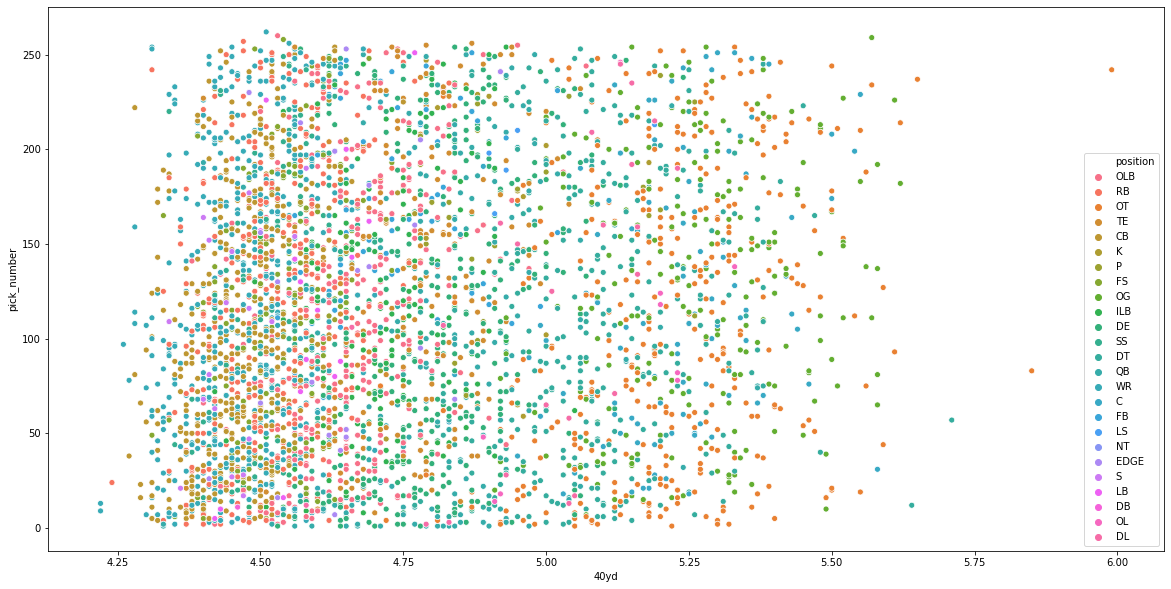

In [231]:
plt.figure(figsize=(20,10))
sns.scatterplot(x='40yd', y='pick_number', hue='position', data=df_combine)

In [240]:
db_df = df_combine[(df_combine['position'] == 'CB') |
                  (df_combine['position'] == 'FS') |
                  (df_combine['position'] == 'SS') |
                  (df_combine['position'] == 'S') |
                  (df_combine['position'] == 'DB')]

In [242]:
db_df.head()

,player,year,position,school,height,weight,40yd,vertical,bench,broad_jump,3cone,shuttle,pick_number
row_id,,,,,,,,,,,,,
5,Rashard Anderson,2000,CB,Jackson St.,74.0,206,4.55000000,34.00000000,NaN,123.0,7.18000000,4.15000000,23.0
10,Reggie Austin,2000,CB,Wake Forest,69.0,175,4.44000000,35.00000000,17.0,119.0,7.03000000,4.14000000,125.0
13,Rashidi Barnes,2000,FS,Colorado,72.0,208,4.62000000,35.00000000,10.0,114.0,6.92000000,4.32000000,225.0
14,David Barrett,2000,CB,Arkansas,70.0,199,4.44000000,37.50000000,16.0,116.0,6.81000000,4.04000000,102.0
15,William Bartee,2000,CB,Oklahoma,73.0,192,4.43000000,38.50000000,NaN,124.0,6.70000000,3.99000000,54.0


In [243]:
df_drafted = df_combine.dropna(subset=['pick_number'])
df_drafted.head()

,player,year,position,school,height,weight,40yd,vertical,bench,broad_jump,3cone,shuttle,pick_number
row_id,,,,,,,,,,,,,
1,John Abraham,2000,OLB,South Carolina,76.0,252,4.55000000,None,NaN,NaN,None,None,13.0
2,Shaun Alexander,2000,RB,Alabama,72.0,218,4.58000000,None,NaN,NaN,None,None,19.0
3,Darnell Alford,2000,OT,Boston Col.,76.0,334,5.56000000,25.00000000,23.0,94.0,8.48000000,4.98000000,188.0
5,Rashard Anderson,2000,CB,Jackson St.,74.0,206,4.55000000,34.00000000,NaN,123.0,7.18000000,4.15000000,23.0
7,LaVar Arrington,2000,OLB,Penn St.,75.0,250,4.53000000,None,NaN,NaN,None,None,2.0


In [245]:
df_drafted['position'].unique()

array(['OLB', 'RB', 'OT', 'CB', 'FS', 'TE', 'OG', 'ILB', 'DE', 'SS', 'QB',
       'WR', 'DT', 'FB', 'K', 'P', 'C', 'LS', 'EDGE', 'S', 'LB', 'DB',
       'OL', 'DL'], dtype=object)

In [275]:
df_drafted = df_drafted.drop(columns=['3cone', 'broad_jump'])

In [290]:
df_drafted = df_drafted.rename(columns={"40yd": "forty"})
df_drafted.head()

,player,year,position,school,height,weight,forty,vertical,bench,shuttle,pick_number
row_id,,,,,,,,,,,
1,John Abraham,2000,OLB,South Carolina,76.0,252,4.55000000,None,NaN,None,13.0
2,Shaun Alexander,2000,RB,Alabama,72.0,218,4.58000000,None,NaN,None,19.0
3,Darnell Alford,2000,OT,Boston Col.,76.0,334,5.56000000,25.00000000,23.0,4.98000000,188.0
5,Rashard Anderson,2000,CB,Jackson St.,74.0,206,4.55000000,34.00000000,NaN,4.15000000,23.0
7,LaVar Arrington,2000,OLB,Penn St.,75.0,250,4.53000000,None,NaN,None,2.0


In [291]:
db_df = df_drafted[(df_drafted['position'] == 'CB') |
                  (df_drafted['position'] == 'FS') |
                  (df_drafted['position'] == 'SS') |
                  (df_drafted['position'] == 'S') |
                  (df_drafted['position'] == 'DB')]
db_df.head()

,player,year,position,school,height,weight,forty,vertical,bench,shuttle,pick_number
row_id,,,,,,,,,,,
5,Rashard Anderson,2000,CB,Jackson St.,74.0,206,4.55000000,34.00000000,NaN,4.15000000,23.0
10,Reggie Austin,2000,CB,Wake Forest,69.0,175,4.44000000,35.00000000,17.0,4.14000000,125.0
13,Rashidi Barnes,2000,FS,Colorado,72.0,208,4.62000000,35.00000000,10.0,4.32000000,225.0
14,David Barrett,2000,CB,Arkansas,70.0,199,4.44000000,37.50000000,16.0,4.04000000,102.0
15,William Bartee,2000,CB,Oklahoma,73.0,192,4.43000000,38.50000000,NaN,3.99000000,54.0


In [292]:
ol_df = df_drafted[(df_drafted['position'] == 'OT') |
                  (df_drafted['position'] == 'OG') |
                  (df_drafted['position'] == 'C') |
                  (df_drafted['position'] == 'OL')]
ol_df.head()

,player,year,position,school,height,weight,forty,vertical,bench,shuttle,pick_number
row_id,,,,,,,,,,,
3,Darnell Alford,2000,OT,Boston Col.,76.0,334,5.56000000,25.00000000,23.0,4.98000000,188.0
12,Mark Baniewicz,2000,OT,Syracuse,78.0,312,5.34000000,28.00000000,20.0,4.73000000,247.0
22,Brad Bedell,2000,OG,Colorado,76.0,302,5.07000000,31.50000000,17.0,4.58000000,206.0
43,Cooper Carlisle,2000,OG,Florida,77.0,297,5.16000000,31.00000000,28.0,4.48000000,112.0
52,Joey Chustz,2000,OT,Louisiana Tech,79.0,304,5.08000000,31.00000000,28.0,4.65000000,123.0


In [293]:
dl_df = df_drafted[(df_drafted['position'] == 'DE') |
                  (df_drafted['position'] == 'DT') |
                  (df_drafted['position'] == 'DL')]
dl_df.head()

,player,year,position,school,height,weight,forty,vertical,bench,shuttle,pick_number
row_id,,,,,,,,,,,
25,Michael Boireau,2000,DE,Miami (FL),76.0,274,5.09000000,29.00000000,26.0,4.49000000,56.0
35,Courtney Brown,2000,DE,Penn St.,77.0,269,4.78000000,None,NaN,None,1.0
45,Leonardo Carson,2000,DE,Auburn,73.0,283,5.06000000,28.00000000,22.0,4.75000000,113.0
55,Kendrick Clancy,2000,DT,Mississippi,73.0,283,5.25000000,27.50000000,25.0,4.65000000,72.0
63,Chris Combs,2000,DT,Duke,77.0,286,5.16000000,None,22.0,None,173.0


In [294]:
lb_df = df_drafted[(df_drafted['position'] == 'OLB') |
                  (df_drafted['position'] == 'ILB') |
                  (df_drafted['position'] == 'EDGE') |
                  (df_drafted['position'] == 'LB')]
lb_df.head()

,player,year,position,school,height,weight,forty,vertical,bench,shuttle,pick_number
row_id,,,,,,,,,,,
1,John Abraham,2000,OLB,South Carolina,76.0,252,4.55000000,None,NaN,None,13.0
7,LaVar Arrington,2000,OLB,Penn St.,75.0,250,4.53000000,None,NaN,None,2.0
23,Marcus Bell,2000,ILB,Arizona,74.0,237,4.78000000,31.50000000,21.0,4.33000000,116.0
38,Keith Bulluck,2000,OLB,Syracuse,75.0,244,4.47000000,38.00000000,NaN,4.13000000,30.0
57,Danny Clark,2000,ILB,Illinois,74.0,245,4.75000000,None,20.0,None,245.0


In [295]:
st_df = df_drafted[(df_drafted['position'] == 'K') |
                  (df_drafted['position'] == 'P') |
                  (df_drafted['position'] == 'LS')]
st_df.head()

,player,year,position,school,height,weight,forty,vertical,bench,shuttle,pick_number
row_id,,,,,,,,,,,
153,Sebastian Janikowski,2000,K,Florida St.,73.0,260,None,None,NaN,None,17.0
184,Shane Lechler,2000,P,Texas A&M,74.0,234,None,None,NaN,None,142.0
439,Nick Harris,2001,P,California,74.0,221,None,None,NaN,None,120.0
492,David Leaverton,2001,P,Tennessee,75.0,211,None,None,NaN,None,142.0
550,Owen Pochman,2001,K,BYU,71.0,179,None,None,NaN,None,216.0


In [296]:
back_df = df_drafted[(df_drafted['position'] == 'RB') |
                    (df_drafted['position'] == 'FB') |
                    (df_drafted['position'] == 'WR') |
                    (df_drafted['position'] == 'TE')]
back_df.head()

,player,year,position,school,height,weight,forty,vertical,bench,shuttle,pick_number
row_id,,,,,,,,,,,
2,Shaun Alexander,2000,RB,Alabama,72.0,218,4.58000000,None,NaN,None,19.0
19,Anthony Becht,2000,TE,West Virginia,78.0,270,4.78000000,33.50000000,NaN,4.08000000,27.0
40,Plaxico Burress,2000,WR,Michigan St.,77.0,231,4.59000000,33.00000000,NaN,None,8.0
42,Trung Canidate,2000,RB,Arizona,71.0,193,4.41000000,None,18.0,None,31.0
49,Doug Chapman,2000,RB,Marshall,70.0,215,4.56000000,38.50000000,16.0,4.20000000,88.0


In [297]:
qb_df = df_drafted[(df_drafted['position'] == 'QB')]
qb_df.head()

,player,year,position,school,height,weight,forty,vertical,bench,shuttle,pick_number
row_id,,,,,,,,,,,
28,Tom Brady,2000,QB,Michigan,76.0,211,5.28000000,24.50000000,NaN,4.38000000,199.0
37,Marc Bulger,2000,QB,West Virginia,74.0,208,4.97000000,None,NaN,4.34000000,168.0
44,Giovanni Carmazzi,2000,QB,Hofstra,75.0,224,4.74000000,36.50000000,NaN,4.23000000,65.0
126,Joe Hamilton,2000,QB,Georgia Tech,70.0,192,4.81000000,None,NaN,None,234.0
143,Todd Husak,2000,QB,Stanford,75.0,216,5.20000000,27.50000000,NaN,4.41000000,202.0


In [305]:
anova_qb_forty = ols('pick_number~forty', data=qb_df).fit()
anova_qb_forty.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            pick_number   R-squared:                       0.425
Model:                            OLS   Adj. R-squared:                  0.159
Method:                 Least Squares   F-statistic:                     1.600
Date:                Tue, 14 Jan 2020   Prob (F-statistic):             0.0104
Time:                        11:27:38   Log-Likelihood:                -1156.8
No. Observations:                 210   AIC:                             2448.
Df Residuals:                     143   BIC:                             2672.
Df Model:                          66                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                          1.5000     51.181      0.029      0.977     -99.668     102.668
forty[T.Decimal('4.40000000')]   191.5000     88.647      2.160      0.032      16.271     366.729
forty[T.Decimal('4.47000000')]   178.5000     88.647      2.014      0.046       3.271     353.729
forty[T.Decimal('4.48000000')]     1.5000     88.647      0.017      0.987    -173.729     176.729
forty[T.Decimal('4.51000000')]     6.5000     88.647      0.073      0.942    -168.729     181.729
forty[T.Decimal('4.52000000')]     0.5000     88.647      0.006      0.996    -174.729     175.729
forty[T.Decimal('4.53000000')]    88.8333     66.074      1.344      0.181     -41.775     219.441
forty[T.Decimal('4.55000000')]    42.5000     88.647      0.479      0.632    -132.729     217.729
forty[T.Decimal('4.56000000')]   130.9000     60.558      2.162      0.032      11.196     250.604
forty[T.Decimal('4.57000000')]   171.5000     72.380      2.369      0.019      28.426     314.574
forty[T.Decimal('4.58000000')]   101.2500     62.683      1.615      0.108     -22.655     225.155
forty[T.Decimal('4.59000000')]   126.2500     62.683      2.014      0.046       2.345     250.155
forty[T.Decimal('4.60000000')]   140.5000     72.380      1.941      0.054      -2.574     283.574
forty[T.Decimal('4.61000000')]    67.3000     60.558      1.111      0.268     -52.404     187.004
forty[T.Decimal('4.63000000')]    78.0000     72.380      1.078      0.283     -65.074     221.074
forty[T.Decimal('4.64000000')]   133.5000     88.647      1.506      0.134     -41.729     308.729
forty[T.Decimal('4.65000000')]     6.8333     66.074      0.103      0.918    -123.775     137.441
forty[T.Decimal('4.66000000')]    10.5000     88.647      0.118      0.906    -164.729     185.729
forty[T.Decimal('4.67000000')]  1.598e-13     72.380   2.21e-15      1.000    -143.074     143.074
forty[T.Decimal('4.68000000')]   183.2500     62.683      2.923      0.004      59.345     307.155
forty[T.Decimal('4.69000000')]    45.8333     66.074      0.694      0.489     -84.775     176.441
forty[T.Decimal('4.70000000')]   194.5000     72.380      2.687      0.008      51.426     337.574
forty[T.Decimal('4.71000000')]    66.0000     57.222      1.153      0.251     -47.110     179.110
forty[T.Decimal('4.72000000')]   172.5000     88.647      1.946      0.054      -2.729     347.729
forty[T.Decimal('4.73000000')]    47.8333     66.074      0.724      0.470     -82.775     178.441
forty[T.Decimal('4.74000000')]    95.5000     66.074      1.445      0.151     -35.108     226.108
forty[T.Decimal('4.75000000')]    41.3333     59.098      0.699      0.485     -75.486     158.153
forty[T.Decimal('4.76000000')]   150.5000     62.683      2.401      0.018      26.595     274.405
forty[T.Decima

In [306]:
qbforty_table = sm.stats.anova_lm(anova_qb_forty, type=2)
print(qbforty_table)

             df         sum_sq      mean_sq         F    PR(>F)
forty      66.0  553373.207359  8384.442536  1.600415  0.010412
Residual  143.0  749165.287879  5238.918097       NaN       NaN


In [309]:
db_corr = db_df.corr()
db_corr

,year,height,weight,bench,pick_number
year,1.000000,0.105940,0.019312,0.005911,-0.010897
height,0.105940,1.000000,0.559526,0.047799,-0.013760
weight,0.019312,0.559526,1.000000,0.356563,-0.013380
bench,0.005911,0.047799,0.356563,1.000000,-0.025108
pick_number,-0.010897,-0.013760,-0.013380,-0.025108,1.000000
